# Day 08. Exercise 00
# Binary classifier. Logistic regression

## 0. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Preprocessing

- Get the data from the file [`checker-timestamp.csv`](https://drive.google.com/file/d/1pooM4cITtG249msX3GK_6W0eEiblzAf5/view?usp=sharing).


- Create a dataframe `df` with the columns: `date`, `am`, `pm`, `target`, where `date` is the date of the day, `am` is the number of the commits during the day before midday (integer), `pm` is the number of commits during the day after midday (integer), `target` is weekend/working_day.

In [309]:
# Загружаем данные
df_raw = pd.read_csv('../data/checker_timestamp.csv')

# Преобразуем timestamp в datetime
df_raw['datetime'] = pd.to_datetime(df_raw['timestamp'])

# Извлекаем дату и время
df_raw['date'] = df_raw['datetime'].dt.date
df_raw['hour'] = df_raw['datetime'].dt.hour
df_raw['weekday'] = df_raw['datetime'].dt.weekday

# Определяем AM (до 12:00) и PM (после 12:00)
df_raw['is_am'] = df_raw['hour'] < 12
df_raw['is_pm'] = df_raw['hour'] >= 12
df_raw
# df_raw.head(50)

,timestamp,datetime,date,hour,weekday,is_am,is_pm
0,2020-04-17 05:19:02.744528,2020-04-17 05:19:02.744528,2020-04-17,5,4,True,False
1,2020-04-17 05:22:35.249331,2020-04-17 05:22:35.249331,2020-04-17,5,4,True,False
2,2020-04-17 05:22:45.549397,2020-04-17 05:22:45.549397,2020-04-17,5,4,True,False
3,2020-04-17 05:34:14.691200,2020-04-17 05:34:14.691200,2020-04-17,5,4,True,False
4,2020-04-17 05:34:24.422370,2020-04-17 05:34:24.422370,2020-04-17,5,4,True,False
...,...,...,...,...,...,...,...
3202,2020-05-21 20:19:06.872761,2020-05-21 20:19:06.872761,2020-05-21,20,3,False,True
3203,2020-05-21 20:22:41.785725,2020-05-21 20:22:41.785725,2020-05-21,20,3,False,True
3204,2020-05-21 20:22:41.877806,2020-05-21 20:22:41.877806,2020-05-21,20,3,False,True
3205,2020-05-21 20:37:00.129678,2020-05-21 20:37:00.129678,2020-05-21,20,3,False,True


In [310]:
# Группируем по дням и считаем коммиты AM/PM
daily_stats = df_raw.groupby('date').agg({
    'is_am': 'sum',  # количество коммитов до полудня
    'is_pm': 'sum',  # количество коммитов после полудня
    'weekday': 'first'  # день недели (берем первое значение, т.к. для одной даты оно одинаковое)
}).reset_index()

daily_stats

,date,is_am,is_pm,weekday
0,2020-04-17,21,2,4
1,2020-04-18,1,68,5
2,2020-04-19,18,15,6
3,2020-04-20,2,23,0
4,2020-04-21,0,25,1
5,2020-04-22,0,28,2
6,2020-04-23,10,33,3
7,2020-04-24,2,14,4
8,2020-04-25,30,74,5
9,2020-04-26,28,233,6


In [311]:
# Переименовываем колонки
daily_stats.columns = ['date', 'am', 'pm', 'weekday']

# Создаем target: weekend (5,6 = суббота, воскресенье) vs working_day (0-4)
daily_stats['target'] = daily_stats['weekday'].apply(
    lambda x: 'weekend' if x >= 5 else 'working_day'
)

# Финальный dataframe
df = daily_stats[['date', 'am', 'pm', 'target']].copy()

print("Dataframe готов!")
print(f"Количество дней: {len(df)}")
print(f"\nРаспределение классов:")
print(df['target'].value_counts())

df

Dataframe готов!
Количество дней: 35

Распределение классов:
target
working_day    25
weekend        10
Name: count, dtype: int64


,date,am,pm,target
0,2020-04-17,21,2,working_day
1,2020-04-18,1,68,weekend
2,2020-04-19,18,15,weekend
3,2020-04-20,2,23,working_day
4,2020-04-21,0,25,working_day
5,2020-04-22,0,28,working_day
6,2020-04-23,10,33,working_day
7,2020-04-24,2,14,working_day
8,2020-04-25,30,74,weekend
9,2020-04-26,28,233,weekend


In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    35 non-null     object
 1   am      35 non-null     int64 
 2   pm      35 non-null     int64 
 3   target  35 non-null     object
dtypes: int64(2), object(2)
memory usage: 1.2+ KB


## 2. Exploratory analysis

- Create a plot where `x` is am, `y` is pm, each dot is a day, working days and weekends must have different colors.


- By looking at the graph do you think it will be easy to classify the days having those two features? Put your answer in the markdown cell in the end of that sectioin: "yes, it is easy" or "no, it is not easy".

In [313]:
# Разделяем данные по классам для разного цвета
working_days = df[df['target'] == 'working_day']
weekends = df[df['target'] == 'weekend']

print(f"working_days AM коммиты: {working_days['am'].sum()} {working_days['am'].sum()/len(working_days)}/день")
print(f"working_days PM коммиты: {working_days['pm'].sum()} {working_days['pm'].sum()/len(working_days)}/день")
print(f"weekend AM коммиты: {weekends['am'].sum()} {weekends['am'].sum()/len(weekends)}/день")
print(f"weekend PM коммиты: {weekends['pm'].sum()} {weekends['pm'].sum()/len(weekends)}/день")

working_days AM коммиты: 344 13.76/день
working_days PM коммиты: 1693 67.72/день
weekend AM коммиты: 227 22.7/день
weekend PM коммиты: 943 94.3/день


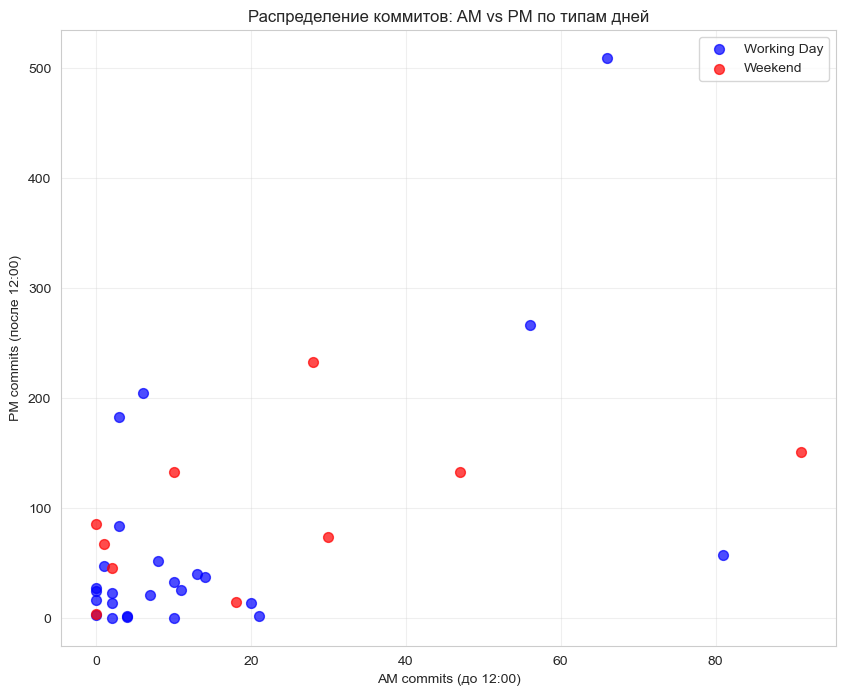

In [314]:
# Создаем scatter plot: x=am, y=pm, цвет=target
plt.figure(figsize=(10, 8))

# Рисуем точки
plt.scatter(working_days['am'], working_days['pm'], 
           c='blue', label='Working Day', alpha=0.7, s=50)
plt.scatter(weekends['am'], weekends['pm'], 
           c='red', label='Weekend', alpha=0.7, s=50)

plt.xlabel('AM commits (до 12:00)')
plt.ylabel('PM commits (после 12:00)')
plt.title('Распределение коммитов: AM vs PM по типам дней')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Этот график показывает ключевую идею feature engineering - как распределение активности в течение дня может помочь различить рабочие дни и выходные.

## Этот график означает:
Оси:

X (горизонталь) = сколько коммитов было ДО 12:00 в конкретный день

Y (вертикаль) = сколько коммитов было ПОСЛЕ 12:00 в тот же день

Цвета: синие = рабочие дни, красные = выходные

### Смысл зависимости PM от AM:

Идея в том, что паттерны активности в течение дня отличаются между рабочими днями и выходными:

### В рабочие дни (синие точки):

Люди обычно более активны днем/вечером (больше PM коммитов)
Утром меньше активности (работа/учеба начинается)

### В выходные (красные точки):

Активность может быть более равномерной
Или смещена к утру (люди просыпаются позже, работают в свое удовольствие)

## Что мы видим на вашем графике:

Основная масса точек сконцентрирована в левом нижнем углу (мало коммитов в оба периода)
Есть несколько выбросов с высокой активностью
Красные и синие точки частично перекрываются, но есть тенденции

## Для хорошей классификации:

Четкое разделение: синие точки в одной области, красные в другой
Например: синие тяготеют к высоким PM, красные к высоким AM
Или любое другое четкое разделение

Вывод по графику: Разделение есть, но не идеальное. Классификация будет возможна, но с  ошибками.

In [ ]:
print("\nСтатистика по классам:")
print("\nWorking days:")
print(f"AM commits: среднее={working_days['am'].mean():.1f}, медиана={working_days['am'].median()}")
print(f"PM commits: среднее={working_days['pm'].mean():.1f}, медиана={working_days['pm'].median()}")

print("\nWeekends:")
print(f"AM commits: среднее={weekends['am'].mean():.1f}, медиана={weekends['am'].median()}")
print(f"PM commits: среднее={weekends['pm'].mean():.1f}, медиана={weekends['pm'].median()}")


Статистика по классам:

Working days:
AM commits: среднее=13.8, медиана=6.0
PM commits: среднее=67.7, медиана=26.0

Weekends:
AM commits: среднее=22.7, медиана=14.0
PM commits: среднее=94.3, медиана=80.0


### Вопрос 1

- By looking at the graph do you think it will be easy to classify the days having those two features? 

no, it is not easy

## 3. Logistic regression

- Train logistic regression on your data using `am` and `pm`, parameters are: `random state=21`, `fit_intercept=False`.


- Make predictions for every day of your dataset and add them to your dataframe with the column name `predict`.


- Save the dataframe into a file in the subfolder of the day `data` with the name `am_pm.csv`.


- Draw another plot like you did before, but the color should be taken from the `predict`.


- By looking at the graph do you think if it made good predictions? Put your answer in the markdown cell in the end of that section: "yes, it is good"; "no, it is not good".

In [316]:
# Подготовка данных для обучения
X = df[['am', 'pm']].values  # признаки
y = df['target'].values      # target

In [317]:
# Обучаем логистическую регрессию
lr_model = LogisticRegression(random_state=21, fit_intercept=False)
lr_model.fit(X, y)
print(lr_model.classes_)  # ['weekend' 'working_day']

['weekend' 'working_day']


In [318]:
# Делаем предсказания
predictions = lr_model.predict(X)

# Добавляем предсказания в dataframe
df['predict'] = predictions
df

,date,am,pm,target,predict
0,2020-04-17,21,2,working_day,weekend
1,2020-04-18,1,68,weekend,working_day
2,2020-04-19,18,15,weekend,working_day
3,2020-04-20,2,23,working_day,working_day
4,2020-04-21,0,25,working_day,working_day
5,2020-04-22,0,28,working_day,working_day
6,2020-04-23,10,33,working_day,working_day
7,2020-04-24,2,14,working_day,working_day
8,2020-04-25,30,74,weekend,working_day
9,2020-04-26,28,233,weekend,working_day


In [319]:
# Сохраняем dataframe
df.to_csv('data/am_pm.csv', index=False)
print("Файл сохранен в data/am_pm.csv")

Файл сохранен в data/am_pm.csv


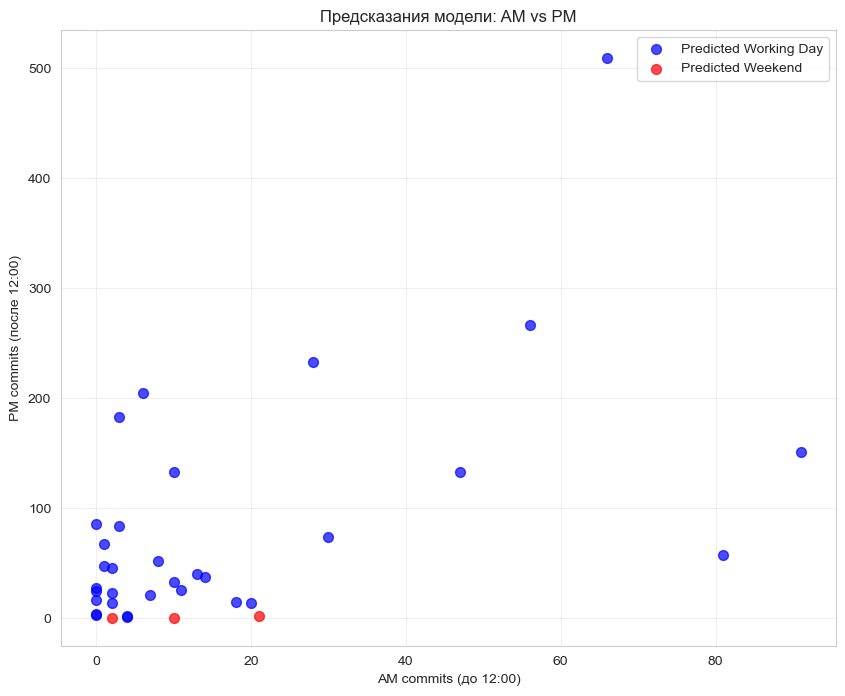

In [320]:
# Рисуем график с предсказаниями
plt.figure(figsize=(10, 8))

# Разделяем данные по предсказанным классам
pred_working = df[df['predict'] == 'working_day']
pred_weekend = df[df['predict'] == 'weekend']

# Рисуем точки по предсказаниям
plt.scatter(pred_working['am'], pred_working['pm'], 
           c='blue', label='Predicted Working Day', alpha=0.7, s=50)
plt.scatter(pred_weekend['am'], pred_weekend['pm'], 
           c='red', label='Predicted Weekend', alpha=0.7, s=50)

plt.xlabel('AM commits (до 12:00)')
plt.ylabel('PM commits (после 12:00)')
plt.title('Предсказания модели: AM vs PM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [321]:
print(f"Коэффициенты модели:")
print(f"AM коэффициент: {lr_model.coef_[0][0]:.4f}")
print(f"PM коэффициент: {lr_model.coef_[0][1]:.4f}")
print(f"Классы: {lr_model.classes_}")

Коэффициенты модели:
AM коэффициент: -0.0004
PM коэффициент: 0.0030
Классы: ['weekend' 'working_day']


In [ ]:
print(f"Сравнение предсказаний:")
comparison = df[['target', 'predict', 'am', 'pm']]
print(comparison.head(10))

Сравнение предсказаний:
        target      predict  am   pm
0  working_day      weekend  21    2
1      weekend  working_day   1   68
2      weekend  working_day  18   15
3  working_day  working_day   2   23
4  working_day  working_day   0   25
5  working_day  working_day   0   28
6  working_day  working_day  10   33
7  working_day  working_day   2   14
8      weekend  working_day  30   74
9      weekend  working_day  28  233


### Вопрос 2

- By looking at the graph do you think if it made good predictions?

no, it is not good

## 4. Evaluation

- Calculate `accuracy` for your predictions.


- Calculate `accuracy` for the naive case when each of your prediction is the value of your most popular class of the day.


- Comparing the accuracies do you think that the classifier made good predictions? Put your answer in the markdown cell in the end of the secion: "yes, it is good"; "no, it is not good".

In [323]:
# Считаем accuracy для наших предсказаний
model_accuracy = accuracy_score(df['target'], df['predict'])
print(f"Accuracy модели: {model_accuracy:.8f} ({model_accuracy*100:.6f}%)")

Accuracy модели: 0.62857143 (62.857143%)


In [324]:
# вычисляем проценты по baseline_accuracy "руками"
print(len(df))
print(len(df[df['target'] == 'working_day']))
print(len(df[df['target'] == 'working_day']) / len(df))

35
25
0.7142857142857143


In [325]:
# массив частотности
df['target'].value_counts()

target
working_day    25
weekend        10
Name: count, dtype: int64

In [326]:
# получение индекса
df['target'].value_counts().index[0]

'working_day'

In [327]:
# получение значения
df['target'].value_counts().iloc[0]

np.int64(25)

In [328]:
# Считаем baseline accuracy (naive предсказания)
# Берем самый частый класс и всегда его предсказываем
most_frequent_class = df['target'].value_counts().index[0]
most_frequent_count = df['target'].value_counts().iloc[0]
baseline_accuracy = most_frequent_count / len(df)

print(f"Самый частый класс: {most_frequent_class}")
print(f"Baseline accuracy: {baseline_accuracy:.8f} ({baseline_accuracy*100:.6f}%)")


Самый частый класс: working_day
Baseline accuracy: 0.71428571 (71.428571%)


In [333]:
# Сравнение
print(f"Сравнение:")
print(f"Модель: {model_accuracy:.8f}")
print(f"Baseline: {baseline_accuracy:.8f}")
print(f"Прирост: {100*(model_accuracy - baseline_accuracy):.2f}% (лол)")

Сравнение:
Модель: 0.62857143
Baseline: 0.71428571
Прирост: -8.57% (лол)


In [330]:
# Confusion matrix для детального анализа
from sklearn.metrics import classification_report
print(f"\nDetailed classification report:")
print(classification_report(df['target'], df['predict']))

# Анализ ошибок
errors = df[df['target'] != df['predict']]
print(f"\nКоличество ошибок: {len(errors)} из {len(df)}")
if len(errors) > 0:
    print("Примеры ошибочных предсказаний:")
    print(errors[['target', 'predict', 'am', 'pm']].head())


Detailed classification report:
              precision    recall  f1-score   support

     weekend       0.00      0.00      0.00        10
 working_day       0.69      0.88      0.77        25

    accuracy                           0.63        35
   macro avg       0.34      0.44      0.39        35
weighted avg       0.49      0.63      0.55        35


Количество ошибок: 13 из 35
Примеры ошибочных предсказаний:
        target      predict  am   pm
0  working_day      weekend  21    2
1      weekend  working_day   1   68
2      weekend  working_day  18   15
8      weekend  working_day  30   74
9      weekend  working_day  28  233


### Вопрос 3

- Comparing the accuracies do you think that the classifier made good predictions?

Нет, предсказания так себе